In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import sys
sys.path.append("..")
from centroid_classifier import CentroidClassifier


# Centroid Classifier

This module is an implementation of the [Nearest Centroid Classification Algorithm](https://en.wikipedia.org/wiki/Nearest_centroid_classifier). This classical algorithm [is implemented in Scikit-Learn in the `sklearn.neighbors.NearestCentroid` module](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html). 

This implementation provides several generalizations to the Nearest Centroid Algorithm, and provides an interface consistent with `Sklearn` classifiers - so that one can use the many great utilities implemented in `Sklearn` to peform tasks such as hyperparameter tuning and cross validation. 

This document covers how to use the `CentroidClassifier`, and covers a case study using the `ionosphere` dataset, from the UCI machine learning repository. 

---

## Contents

### 1. Nearest Centroid Algorithm
- 1.1 Classical algorithm
- 1.2 Drawbacks of Nearest Centroid classification

### 2. Extensions to classical algorithm
- 2.1 Mahalanobis and skew distances
- 2.2 Reframing one classification problem as another

### 3. Case study - Ionosphere dataset
- 3.1 `iononsphere` dataset
- 3.2 Basic functionality of `CentroidClassifier` class
---

## 1. Nearest Centroid Algorithm

#### 1.1 Classical algorithm

The Nearest Centroid algorithm is a simple supervised learning algorithm. During training, the mean (centroid) of the training data for each label (response) is calculated. To predict the class of a new vector, the distance between the vector and each of the class centroids is calculated, and vector is assigned to the class whose centroid it is closes to. 

Those familiar with the `Kmeans` unsupervised clustering algorithm may recognize that the prediction step is identical to the label updated stip in the `Kmeans` algorithm. 


#### 1.2 Drawbacks of Nearest Centroid classification

The Nearest Centroid algorithm is a simple and efficient method. It has no hyperparameters - which makes it a practical baseline classifier. 

The algorithm performs poorly under certain circumstances, however. First - it does not handle non-convex classes well. Secondly, when using Euclidean distance as the distance measure - the algorithm struggles when the classes have drastically different variances and/or skews. 

## 2. Extensions to classical algorithm

#### 2.1 Mahalanobis and Skew distances

When using Euclidean distance to a class centroid, the covariance in the data is ignored. Therefore, in the image below, points `1` and `2` are considered to be the same distance away from the origin.  

![](images/euc_contour.png)

However, in light of the rest of the data, it's clear that point `1` deviates from the origin more extremely than `2`, since point `2` falls in the cloud of the rest of the data. Ingoring the covariance in the data leads us to ignore this fact. 

Mahalanobis distance addresses this issue. According to Wikipedia, "it is a multi-dimensional generalization of the idea of measuring how many standard deviations away [a point] is from the mean [of a set of vectors]." Thus, the covariance in the data is accounted for. A countour plot of the Mahalanobis distance better reflects the general shape of the data, and captures the intuition of measuring how "unusually far" a point is from the mean more naturally. 

![](images/mah_contour.png)
*Images courtesy of [Vincent Zoonekynd](http://zoonek2.free.fr/UNIX/48_R/06.html)*


In this module, we extend Scikit-Learn's implementation of the Nearest Centroid algorithm by impementing the Mahalanobis distance for classification. We also implemented a novel distance metric - _skew distance_ - which takes into account the skew in principle components of a datset - as proposed by [Dr. Mark DeBonis](https://manhattan.edu/campus-directory/mark.debonis) in his paper [_"Using Skew for Classification"_](https://www.google.com/search?q=using+skew+for+classification&oq=using+skew+for+classification&aqs=chrome..69i57j69i60j69i61l2j35i39.3895j0j7&sourceid=chrome&ie=UTF-8)


#### 2.2 Reframing one classification problem as another

In the classical Nearest Centroid algorithm, the predicted class of a vector is the class whose centroid is closest to that vector.

We generalize this decision criterion by reframing the original classification task as a seperate auxuilliary classification task. For a data matrix **X** of shape (n, m), and a response vector **y** with `k` unique classes, the classification task is transformed as follows:

1. For each class _c_, compute the centroid of $X_c$, where $X_c \equiv \{X_i  \text{ : }\quad y_i = c\}$
2. For each training example $x \in I\!R^{m}$, construct a vector in $I\!R^k$, $x'$, where the $j^{th}$ component of $x'$ is the distance between $x$ and the $j^{th}$ cluster centroid. Call the collection of these constructed vectors **X'**.  
3. Now we have a design matrix **X'**, of dimension (n, k), and the same vector of labels, **y**. These matrices define the new classification task. 

This setup is a generalization of the classic decision criterion, and allows for the use of arbirary classification methods to be used to solve the constructed classification task (e.g. SVM, Logistic Regression, KNN, etc).

This design choice was to help make this classifier generalizable to a wide variety of datasets, and allow it to learn more complex decision boundaries. 

---

## 3. Case study - Ionosphere dataset

To introduce the interface to the `CentroidClassifier` object and provide a point of reference to its performance, I will apply it to the `ionosphere` dataset from the UCL Machine Learning repository.


#### 3.1 `iononsphere` dataset

The `iononsphere` dataset consists of radar measurements from 16 antenae, and labels that indicate if the measurement is suitable for further analysis not. There are 351 instances and 34 features in the data. 

In [2]:
ion = pd.read_csv("datasets/ionosphere.csv")
ion.head()

,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,...,a26,a27,a28,a29,a30,a31,a32,a33,a34,class
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


A natural classification task is to predict if a measurement is good or bad. 

Here I split up the data into training and test splits, for experimentation. 

In [3]:
# isolate design matrix and response vector
X = ion.iloc[:,:-1]
y = ion.iloc[:,-1]

# Make training and test splits for experimentation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [4]:
# sanity check - do dimensions make sense? 
print X.shape, y.shape
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(351, 34) (351,)
(280, 34) (280,)
(71, 34) (71,)


#### 3.2 Basic functionality of `CentroidClassifier` class

The `CentroidClassifier` adopts the same interface as any `sklearn` classifier. As such, it has `fit()` and `predict()` static methods. 

In [5]:
# Initialize a nearest-centroid classifier
clf = CentroidClassifier()

By default, the distance used for classification is Mahalanbois distance. One can also pass the optional parameter `distance` to one of:

- `mahalanobis`
- `skew`
- `euclidean`
- `chebyshev`
- `manhattan`


In [6]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

CentroidClassifier(classifier=None, distance=None)

In [7]:
# demonstration of how to use prediction method
clf.predict(X_test)

array(['g', 'g', 'b', 'g', 'g', 'g', 'g', 'g', 'b', 'b', 'g', 'g', 'b',
       'g', 'b', 'g', 'g', 'g', 'g', 'b', 'g', 'g', 'g', 'g', 'b', 'g',
       'g', 'g', 'g', 'g', 'b', 'g', 'b', 'b', 'g', 'g', 'g', 'b', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'b', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'b', 'b', 'g', 'g', 'b', 'g', 'b', 'b',
       'g', 'b', 'g', 'g', 'b', 'g'],
      dtype='|S1')

For binary classification tasks, one can also plot the decision boundary fit using the `plot_boundary()` static method:


ValueError: could not convert string to float: g

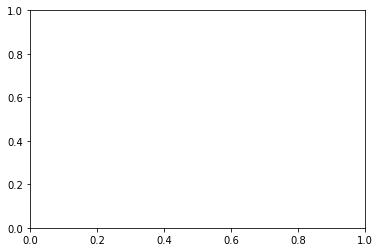

In [8]:
clf.plot_boundary(X_train, y_train)